# SHAP (Interpretability of models)

SHAP (SHapley Additive exPlanations) by Lundberg and Lee [(2016)](https://arxiv.org/abs/1705.07874) is a method to explain individual predictions. SHAP is based on the game theoretically optimal Shapley Values. The goal of SHAP is to explain the prediction of an instance x by computing the contribution of each feature to the prediction [(Ref 1)](https://christophm.github.io/interpretable-ml-book/shapley.html#shapley).

Documentation of package [1](https://github.com/slundberg/shap), [2](https://shap.readthedocs.io/en/latest/).


In [ ]:
! pip install shap

     |████████████████████████████████| 358kB 4.1MB/s 
  Created wheel for shap: filename=shap-0.38.1-cp36-cp36m-linux_x86_64.whl size=489413 sha256=947fa8e3efdf42c662c727ede3221177c9a510c9df405797c126bf24cf306119
  Stored in directory: /root/.cache/pip/wheels/a8/fb/e4/88012be41842b9be62ae18d82d1b1e880daf8539d1fef1fa00
Successfully built shap


# Libraries

In [ ]:
%reload_ext autoreload
%autoreload 2

# visualisation and data manipulation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
pd.set_option('display.max_columns', 200)


# system and files managment
import os
import sys
import pickle
import ast
import collections

# model splits
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE

# model
import xgboost as xg

import shap


import warnings
warnings.filterwarnings('ignore')

# Loading Data

In [ ]:
df = pd.read_pickle('extended_data_set_pred_01_GA.pick')

In [ ]:
list_var_GA = ['latitude', 'longitude', 'accommodates', 'bedrooms', 'maximum_nights',
       'availability_30', 'bathrooms_shared', 'room_type_num', 'tv',
       'hot_water', 'dishwasher', 'cable_tv']

In [ ]:
price_col = ['price_log', 'price' , 
             'predicted_price_log_01_GA', 'predicted_price_01_GA']

In [ ]:
y = df['price_log'].values

In [ ]:
X = df[list_var_GA].copy()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    random_state=42)

In [ ]:
X_train.head()

,latitude,longitude,accommodates,bedrooms,maximum_nights,availability_30,bathrooms_shared,room_type_num,tv,hot_water,dishwasher,cable_tv
73063,51.48142,-0.20365,2,1.0,1125,29,1.0,2,0.0,0.0,0.0,0.0
20196,51.49249,-0.11610,4,1.0,365,9,0.0,1,1.0,1.0,0.0,0.0
54900,51.45595,-0.10912,2,1.0,3,30,0.0,2,1.0,1.0,0.0,0.0
72774,51.53232,-0.23976,2,1.0,1125,24,0.0,2,1.0,1.0,0.0,0.0
16239,51.47559,-0.02929,2,1.0,1125,30,1.0,2,1.0,1.0,1.0,0.0


## Observations with lower prices 

In [ ]:
# Low price
df.loc[(df.index.isin(X_test.index)) & (df['price'] < 16), price_col].head(16)

,price_log,price,predicted_price_log_01_GA,predicted_price_01_GA
947,2.564949,13.0,3.670364,39.266193
5440,2.708050,15.0,3.316216,27.555895
6014,2.708050,15.0,3.529160,34.095329
8856,2.708050,15.0,3.632825,37.819496
9326,2.484907,12.0,3.303283,27.201790
11318,2.639057,14.0,3.009396,20.275146
12872,2.484907,12.0,3.594811,36.408833
13445,2.708050,15.0,3.277385,26.506367
13535,2.484907,12.0,3.251200,25.821318
13600,2.397895,11.0,3.360598,28.806398


## Observations with hihg prices 

In [ ]:
# High 
df.loc[(df.index.isin(X_test.index)) & (df['price'] > 500), price_col].head(16)

,price_log,price,predicted_price_log_01_GA,predicted_price_01_GA
2935,6.228511,507.0,6.088206,440.630157
3965,6.255750,521.0,5.785707,325.612335
4689,6.347389,571.0,5.387963,218.757385
8566,6.335054,564.0,5.838081,343.120239
11751,6.309918,550.0,5.614293,274.319397
13666,6.287859,538.0,6.084032,438.794678
16466,6.309918,550.0,5.540142,254.714066
17461,6.248043,517.0,5.935747,378.322540
19655,6.240276,513.0,5.641706,281.943451
19851,6.304449,547.0,5.579526,264.946106


## Observations with medium prices 

In [ ]:
# Meadium
df.loc[(df.index.isin(X_test.index)) & (df['price'] == 100), price_col].head(16)

,price_log,price,predicted_price_log_01_GA,predicted_price_01_GA
578,4.60517,100.0,3.536704,34.353512
795,4.60517,100.0,4.616365,101.125816
857,4.60517,100.0,3.546473,34.690739
1042,4.60517,100.0,4.127611,62.029572
1049,4.60517,100.0,4.462593,86.712074
1401,4.60517,100.0,4.566101,96.168419
1958,4.60517,100.0,4.479772,88.214523
2329,4.60517,100.0,4.817716,123.682289
2530,4.60517,100.0,4.565935,96.152458
2637,4.60517,100.0,4.141788,62.915215


In [ ]:
loaded_model = xg.Booster()
loaded_model.load_model("price_model_fina_02_GA_02.model")

In [ ]:
loaded_model.predict(xg.DMatrix(X_train))

array([3.831995 , 4.4349747, 4.176568 , ..., 4.142328 , 3.7166798,
       3.5958693], dtype=float32)

In [ ]:
X_test_dm = xg.DMatrix(X_test)

# Shaply

In [ ]:
# explainer_xgb = shap.Explainer(loaded_model, X_test)
# shap_values_xgb = explainer_xgb.shap_values(X_test)

100%|===================| 15185/15223 [02:47<00:00]       

Getting tha Shaply object 

In [ ]:
explainer_xgb_t = shap.TreeExplainer(loaded_model, X_test, feature_dependece="independent")
shap_values_xgb_t = explainer_xgb_t.shap_values(X_test)

100%|===================| 15193/15223 [01:07<00:00]       

In [ ]:
explainer_xgb_tt = shap.TreeExplainer(loaded_model, X_test, feature_dependece="independent")

In [ ]:
shap_values_xgb_tt = explainer_xgb_tt(X_test)

 99%|===================| 15050/15223 [01:06<00:00]       

## Examine how changes in a feature change the model's prediction.

A dependence scatter plot shows the effect a single feature has on the predictions made by the model.

Each dot is a single prediction (row) from the dataset.
* The x-axis is the value of the feature (from the X matrix, stored in shap_values.data).
* The y-axis is the SHAP value for that feature (stored in shap_values.values), which represents how much knowing that feature's value changes the output of the model for that sample's prediction. 
* The light grey area at the bottom of the plot is a histogram showing the distribution of data values.
* In the left is shown which feature may be driving interaction effects with the variable in the x-axis by colouring the variable dependence scatter plot by that feature. If we pass the entire Explanation object to the color parameter then the scatter plot attempts to pick out the feature column with the strongest interaction with the one in the x-axis.

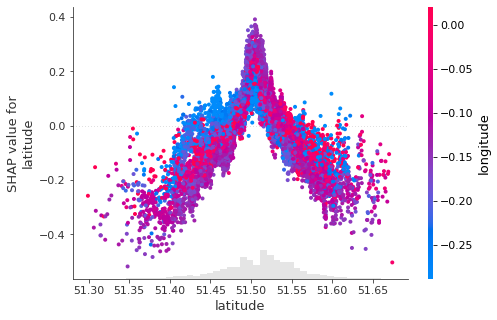

In [ ]:
shap.plots.scatter(shap_values=shap_values_xgb_tt[:,'latitude'], color=shap_values_xgb_tt)

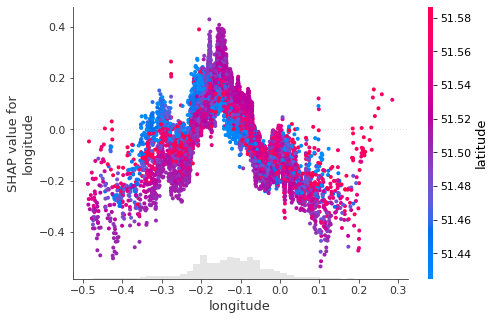

In [ ]:
shap.plots.scatter(shap_values=shap_values_xgb_tt[:,'longitude'], color=shap_values_xgb_tt)

map_room_type = {'Entire home/apt':1, 'Private room':2, 'Shared room':3, 'Hotel room':4}

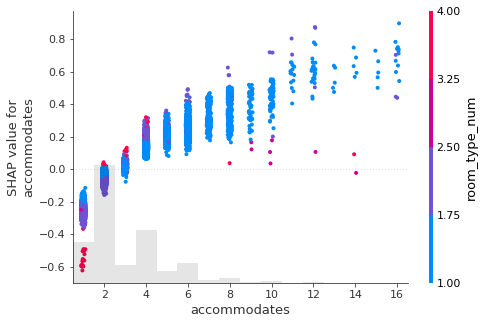

In [ ]:
shap.plots.scatter(shap_values=shap_values_xgb_tt[:,'accommodates'], color=shap_values_xgb_tt)

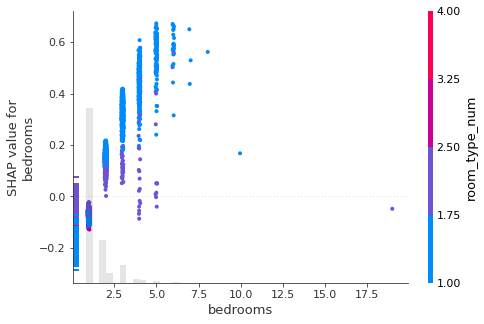

In [ ]:
shap.plots.scatter(shap_values=shap_values_xgb_tt[:,'bedrooms'], color=shap_values_xgb_tt)

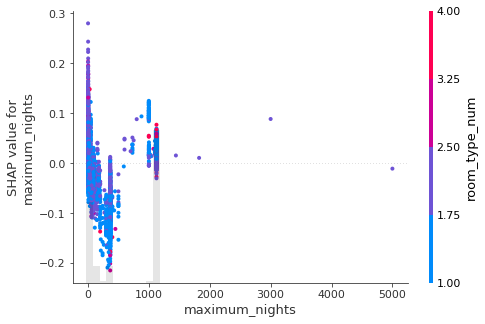

In [ ]:
shap.plots.scatter(shap_values=shap_values_xgb_tt[:,'maximum_nights'], color=shap_values_xgb_tt)

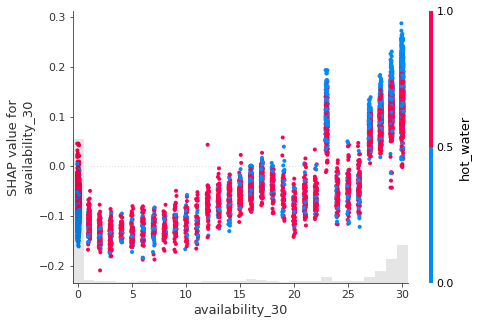

In [ ]:
shap.plots.scatter(shap_values=shap_values_xgb_tt[:,'availability_30'], color=shap_values_xgb_tt)

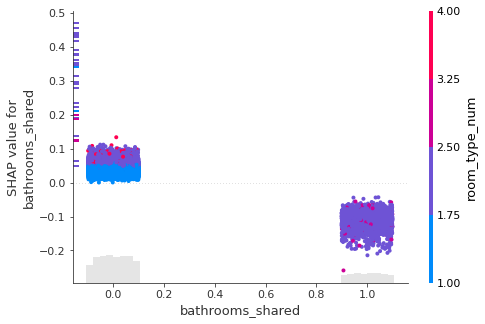

In [ ]:
shap.plots.scatter(shap_values=shap_values_xgb_tt[:,'bathrooms_shared'], color=shap_values_xgb_tt)

map_room_type = {'Entire home/apt':1, 'Private room':2, 'Shared room':3, 'Hotel room':4}

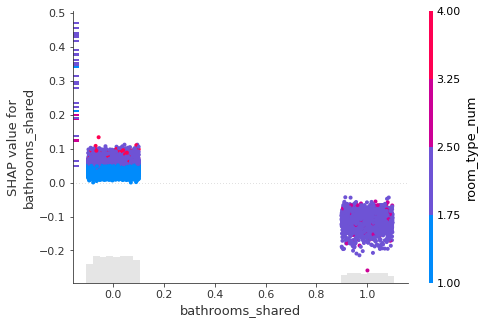

In [ ]:
shap.plots.scatter(shap_values=shap_values_xgb_tt[:,'bathrooms_shared'], color=shap_values_xgb_tt)

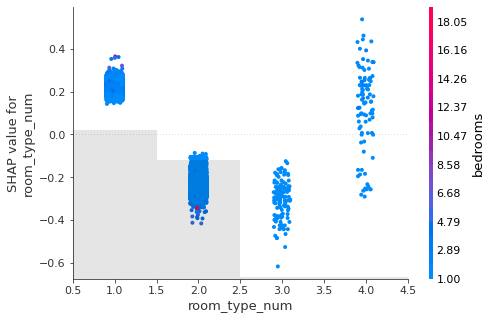

In [ ]:
shap.plots.scatter(shap_values=shap_values_xgb_tt[:,'room_type_num'], color=shap_values_xgb_tt)

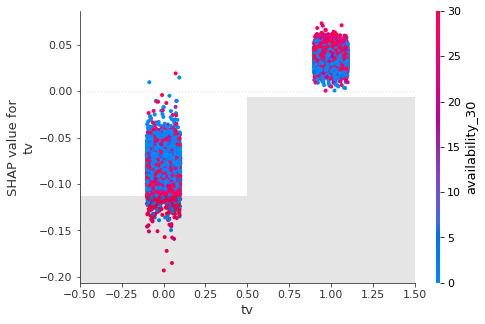

In [ ]:
shap.plots.scatter(shap_values=shap_values_xgb_tt[:,'tv'], color=shap_values_xgb_tt)

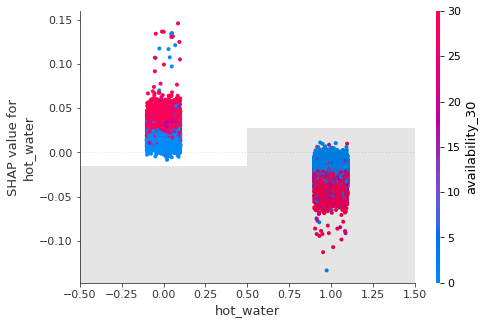

In [ ]:
shap.plots.scatter(shap_values=shap_values_xgb_tt[:,'hot_water'], color=shap_values_xgb_tt)

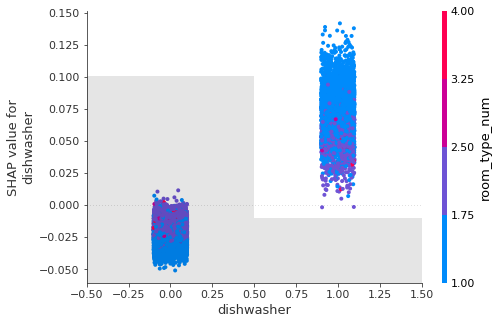

In [ ]:
shap.plots.scatter(shap_values=shap_values_xgb_tt[:,'dishwasher'], color=shap_values_xgb_tt)

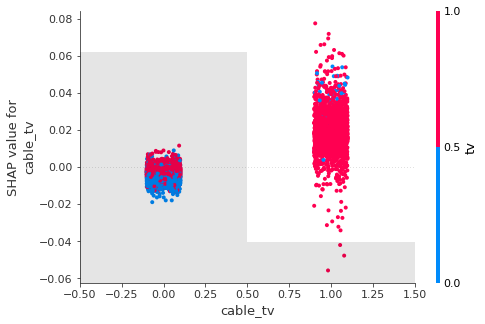

In [ ]:
shap.plots.scatter(shap_values=shap_values_xgb_tt[:,'cable_tv'], color=shap_values_xgb_tt)

In [ ]:
explainer_xgb_tt_02 = shap.Explainer(loaded_model, X_test, feature_dependece="independent")

In [ ]:
shap_values_xgb_tt_02 = explainer_xgb_tt_02(X_test)

 99%|===================| 15040/15223 [01:06<00:00]       

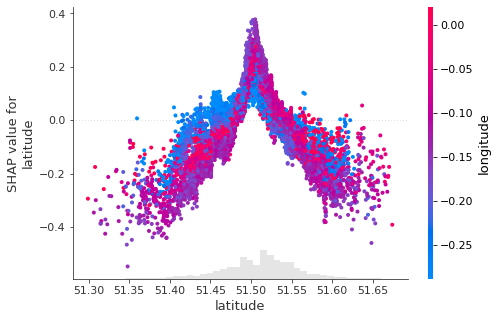

In [ ]:
# shap.plots.scatter(shap_values=shap_values_xgb_tt_02[:,'latitude'], color=shap_values_xgb_tt_02)

## bar plots

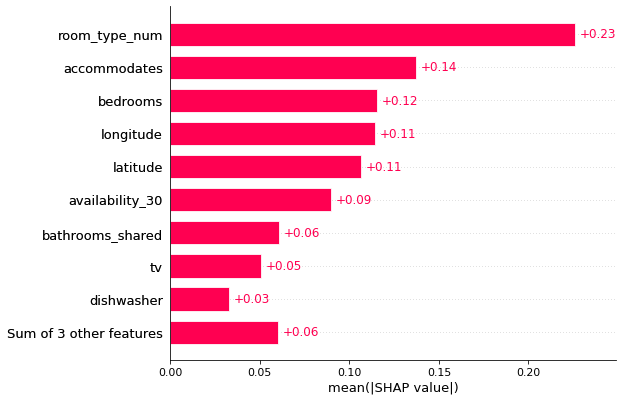

In [ ]:
shap.plots.bar(shap_values_xgb_tt)

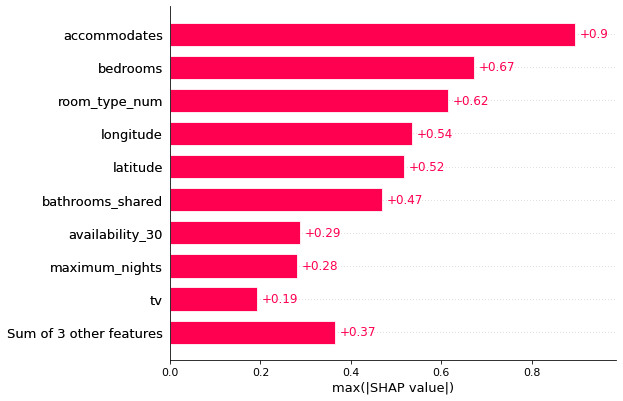

In [ ]:
shap.plots.bar(shap_values_xgb_tt.abs.max(0))

In [ ]:
clustering = shap.utils.hclust(X_test, y_test)

[18:26:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:26:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:26:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:26:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:26:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:26:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:26:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:26:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

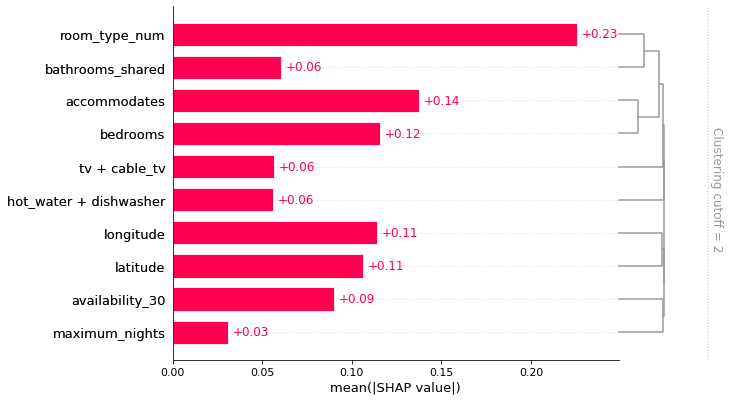

In [ ]:
shap.plots.bar(shap_values_xgb_tt, clustering=clustering, clustering_cutoff=2)

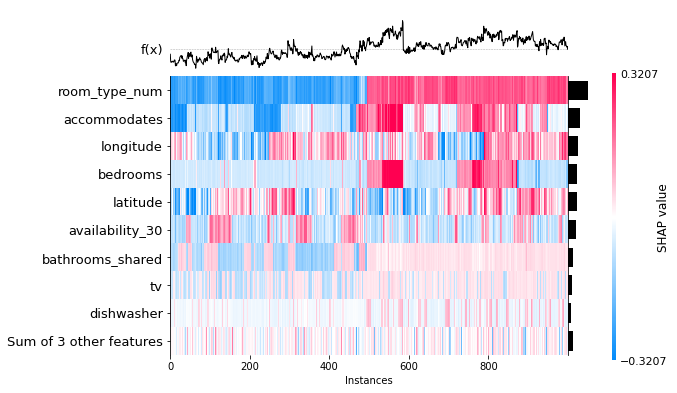

In [ ]:
shap.plots.heatmap(shap_values_xgb_tt[:1000])

## Summarize the impact of all features over the entire dataset.
A SHAP value for a feature of a specific prediction represents how much the model prediction changes when we observe that feature. 

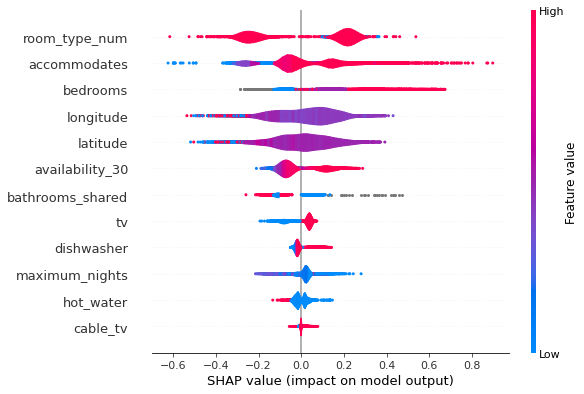

In [ ]:
shap.summary_plot(shap_values_xgb_tt, X_test, plot_type="violin")

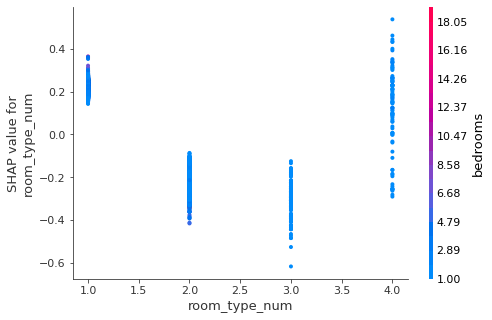

In [ ]:

shap.dependence_plot('room_type_num', shap_values_xgb_t, X_test)

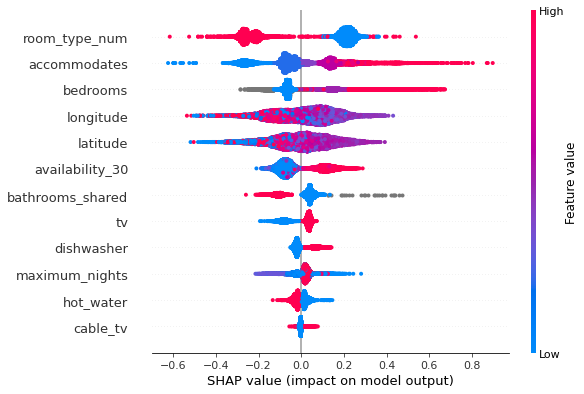

In [ ]:
shap.plots.beeswarm(shap_values_xgb_tt_02, max_display=14)

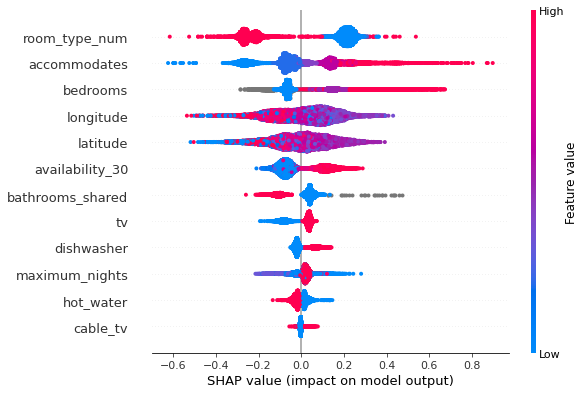

In [ ]:
shap.summary_plot(shap_values_xgb_tt_02, X_test)

## The additive nature of Shapley values

One the fundemental properties of Shapley values is that they always sum up to the difference between the game outcome when all players are present and the game outcome when no players are present. For machine learning models this means that SHAP values of all the input features will always sum up to the difference between baseline (expected) model output and the current model output for the prediction being explained. The easiest way to see this is through a waterfall plot that starts our background prior expectation for a home price $E[f(X)]$, and then adds features one at a time until we reach the current model output $f(x)$ [(Ref 1)](https://render.githubusercontent.com/view/ipynb?color_mode=light&commit=f9bcf8a9610dcd0716dde8270f1266c2a24bd394&enc_url=68747470733a2f2f7261772e67697468756275736572636f6e74656e742e636f6d2f736c756e64626572672f736861702f663962636638613936313064636430373136646465383237306631323636633261323462643339342f6e6f7465626f6f6b732f6f76657276696577732f416e253230696e74726f64756374696f6e253230746f2532306578706c61696e61626c65253230414925323077697468253230536861706c657925323076616c7565732e6970796e62&nwo=slundberg%2Fshap&path=notebooks%2Foverviews%2FAn+introduction+to+explainable+AI+with+Shapley+values.ipynb&repository_id=74505259&repository_type=Repository#The-additive-nature-of-Shapley-values).

Here are some observations in different ranges of price

### Low price

In [ ]:
sample_ind_low = 947

In [ ]:
data_for_pred_low = X_test.loc[[sample_ind_low]]
data_for_pred_low

,latitude,longitude,accommodates,bedrooms,maximum_nights,availability_30,bathrooms_shared,room_type_num,tv,hot_water,dishwasher,cable_tv
947,51.534,-0.0358,1,1.0,90,0,0.0,2,1.0,1.0,1.0,1.0


In [ ]:
data_for_pred_low_dm = xg.DMatrix(data_for_pred_low)

In [ ]:
loaded_model.predict(data_for_pred_low_dm)

array([3.7311456], dtype=float32)

In [ ]:
np.exp(3.670364)

39.266196154713455

In [ ]:
explainer_low_exa = shap.TreeExplainer(loaded_model)

In [ ]:
shape_value_low_exa = explainer_low_exa.shap_values(data_for_pred_low)

In [ ]:
shape_value_low_exa_01 = explainer_low_exa(data_for_pred_low)

In [ ]:
shape_value_low_exa

array([[ 0.0052851 , -0.15787679, -0.20689905, -0.07593284,  0.00952446,
        -0.04439319,  0.08766407, -0.34929597,  0.0403932 ,  0.00749296,
         0.06222306,  0.0240146 ]], dtype=float32)

In [ ]:
shap.initjs()
shap.force_plot(explainer_low_exa.expected_value, shape_value_low_exa[0], data_for_pred_low)

In [ ]:
shap.initjs()
shap.force_plot(explainer_xgb_t.expected_value, shap_values_xgb_t[0:500,:], X_test[0:500])

In [ ]:
shape_value_low_exa

array([[ 0.0052851 , -0.15787679, -0.20689905, -0.07593284,  0.00952446,
        -0.04439319,  0.08766407, -0.34929597,  0.0403932 ,  0.00749296,
         0.06222306,  0.0240146 ]], dtype=float32)

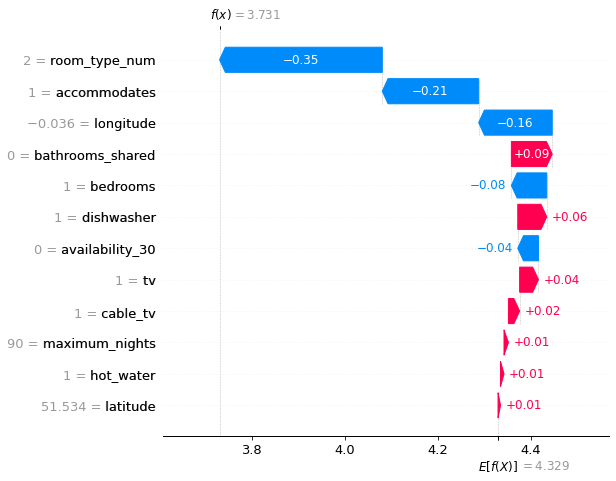

In [ ]:
shap.plots.waterfall(shape_value_low_exa_01[0], max_display=12)

### Medium price

In [ ]:
sample_ind_mead = 2329

In [ ]:
data_for_pred_mead = X_test.loc[[sample_ind_mead]]
data_for_pred_mead

,latitude,longitude,accommodates,bedrooms,maximum_nights,availability_30,bathrooms_shared,room_type_num,tv,hot_water,dishwasher,cable_tv
2329,51.54005,-0.06748,7,2.0,30,0,0.0,1,1.0,1.0,0.0,1.0


In [ ]:
data_for_pred_mead_dm = xg.DMatrix(data_for_pred_mead)

In [ ]:
loaded_model.predict(data_for_pred_mead_dm)

array([4.858917], dtype=float32)

In [ ]:
np.exp(4.817716)

123.68227760806982

In [ ]:
explainer_mead_exa = shap.TreeExplainer(loaded_model)

In [ ]:
shape_value_mead_exa = explainer_mead_exa.shap_values(data_for_pred_mead)

In [ ]:
shape_value_mead_exa_01 = explainer_mead_exa(data_for_pred_mead)

In [ ]:
shape_value_mead_exa

array([[ 0.04554208, -0.08088222,  0.23686272,  0.10460249, -0.02552433,
        -0.04693929,  0.02211322,  0.25927886,  0.02908388, -0.00882788,
        -0.02321054,  0.0178712 ]], dtype=float32)

In [ ]:
shap.initjs()
shap.force_plot(explainer_mead_exa.expected_value, shape_value_mead_exa[0], data_for_pred_mead)

In [ ]:
shape_value_mead_exa

array([[ 0.04554208, -0.08088222,  0.23686272,  0.10460249, -0.02552433,
        -0.04693929,  0.02211322,  0.25927886,  0.02908388, -0.00882788,
        -0.02321054,  0.0178712 ]], dtype=float32)

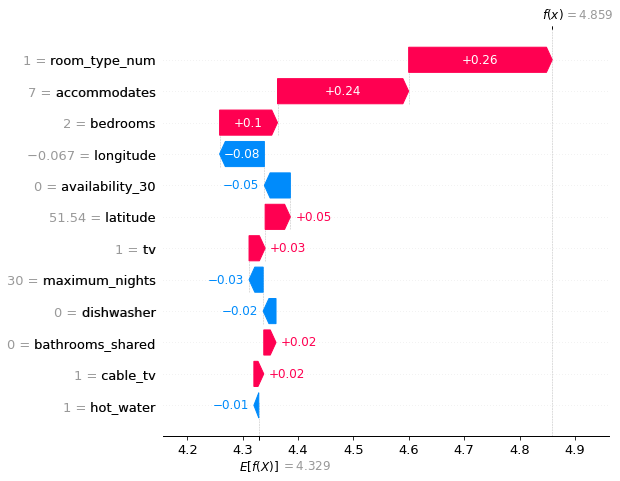

In [ ]:
shap.plots.waterfall(shape_value_mead_exa_01[0], max_display=12)

### High price

In [ ]:
sample_ind_high = 17461

In [ ]:
data_for_pred_high = X_test.loc[[sample_ind_high]]
data_for_pred_high

,latitude,longitude,accommodates,bedrooms,maximum_nights,availability_30,bathrooms_shared,room_type_num,tv,hot_water,dishwasher,cable_tv
17461,51.49333,-0.18517,7,4.0,1125,1,0.0,1,1.0,0.0,1.0,0.0


In [ ]:
data_for_pred_high_dm = xg.DMatrix(data_for_pred_high)

In [ ]:
loaded_model.predict(data_for_pred_high_dm)

array([5.9221277], dtype=float32)

In [ ]:
np.exp(5.935747)

378.32249754991216

In [ ]:
explainer_high_exa = shap.TreeExplainer(loaded_model)

In [ ]:
shape_value_high_exa = explainer_high_exa.shap_values(data_for_pred_high)

In [ ]:
shape_value_high_exa_01 = explainer_high_exa(data_for_pred_high)

In [ ]:
shape_value_high_exa

array([[ 0.157318  ,  0.20582685,  0.29574075,  0.45999303,  0.03245477,
        -0.07692854,  0.02488453,  0.32818067,  0.04915431,  0.02057468,
         0.09833965, -0.0023553 ]], dtype=float32)

In [ ]:
shap.initjs()
shap.force_plot(explainer_high_exa.expected_value, shape_value_high_exa[0], data_for_pred_high)

In [ ]:
shape_value_high_exa

array([[ 0.157318  ,  0.20582685,  0.29574075,  0.45999303,  0.03245477,
        -0.07692854,  0.02488453,  0.32818067,  0.04915431,  0.02057468,
         0.09833965, -0.0023553 ]], dtype=float32)

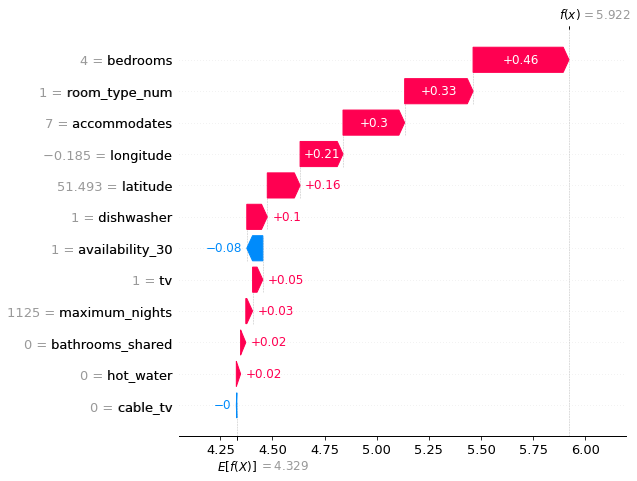

In [ ]:
shap.plots.waterfall(shape_value_high_exa_01[0], max_display=12)